# Text Representation

In [68]:
import gzip
import os
import sys
sys.path.append('../')
import pickle
import pandas as pd
import json
import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


train = pd.read_pickle("files/train.pkl")
test = pd.read_pickle("files/test.pkl")
meta = getDF('files/meta_Software.json.gz')
print("Before dropping dups:", len(meta))

meta = meta.drop_duplicates(["asin"], keep="last")
print("After:", len(meta))


Before dropping dups: 26790
After: 21639


In [69]:
# filter out products that are not in train or test sets 
allowed_asins = np.unique(np.array([*train.asin.to_list(), *test.asin.to_list()]))
meta = meta[meta["asin"].isin(allowed_asins)].reset_index(drop=True)

len(allowed_asins), len(meta)

(801, 801)

In [70]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from bs4 import BeautifulSoup
import re
from pattern.en import lemma

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:

def cleanWords(x):
    x = BeautifulSoup(x).get_text()        #remove html
    x = re.sub("[^a-z]", " ", x.lower())   #lowercase and only letters
    x   = word_tokenize(x)                 #tokenize
    stops = set(stopwords.words("english"))        
    x = [w for w in x if not w in stops]   #remove stopwords 
    ps = PorterStemmer()                           
    x = [ps.stem(w) for w in x]            #stem
    return ' '.join([w for w in x if len(w)>1])

def cleanPrices(x): 
    x = x[1:]  
    try:
        x = float(x)
    except:
        x = 67.02 #mean of non-nan prices
    return x

def countWordsAndLengths(x):
    x = BeautifulSoup(x).get_text()
    x = re.sub("[^a-z]", " ", x.lower())
    x = word_tokenize(x)
    return pd.Series([len(x), len(''.join(x))/len(x)])

df = meta.copy()

df["prices"]  = df["price"].apply(lambda x: cleanPrices(x))

df["all_text"] = df[["title", "brand", "description", "category"]].apply(
    lambda x: x["title"] + " " + x["brand"] + " " + (' '.join(x["description"])) \
                                            + " " + (' '.join(x["category"])), axis=1)

df[["n_words", "avg_word_length"]] = df["all_text"].apply(lambda x: countWordsAndLengths(x))

df["words"] = df["title"].apply(lambda x: cleanWords(x))
# df["all_words"] = df["all_text"].apply(lambda x: cleanWords(x))

## other arbitrary features ##
# df["below50"] =  df["prices"].apply(lambda x: (x<50)*1.)
# df["below150"] =  df["prices"].apply(lambda x: (x<150)*1.)
# .. 
# LIX readability of description, etc... 
df["words"]

0                   learn adob photoshop lightroom video
1      learn adob dreamweav cs video core train web c...
2      learn adob flash profession cs video core trai...
3      microsoft offic home year subscript user pc ma...
4                        niv glo premium dvd multi devic
                             ...                        
796    microsoft offic home student famili pack pc di...
797    corel aftershot pro photo edit softwar pc mac ...
798                               onlinetv free download
799                     pinnacl studio ultim old version
800                       pinnacl studio plu old version
Name: words, Length: 801, dtype: object

In [72]:
# unique words in vocab (excludes 1-letter stems)
len(set(' '.join(df["words"]).split(' ')))

646

## TF-IDF


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df["words"])
tfidf = tfidf_vectorizer.fit_transform(df["words"])
names = tfidf_vectorizer.get_feature_names_out()
arr = tfidf.toarray() 

df2 = pd.DataFrame(arr, index=df["asin"], columns=names)
df2.to_pickle("files/asin_tfidf1.pkl")
df2

,access,account,acroni,activ,address,adob,advanc,advantag,advisor,aftershot,...,work,world,write,xi,xp,xpvistawin,year,youtub,yr,zonealarm
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.0,0.0,0.0,0.0,0.0,0.416422,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
0321719816,0.0,0.0,0.0,0.0,0.0,0.287289,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
0321719824,0.0,0.0,0.0,0.0,0.0,0.269974,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
0763855553,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.35918,0.0,0.0,0.0
0982697813,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
B01FFVDY9M,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.479046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
B01H39M7ME,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


## TF-IDF similarity example


In [74]:
from sklearn.metrics.pairwise import cosine_similarity

asins = ["B001DSGXFY", "B01HAP47PQ", "B01HAP3NUG"]
sims = pd.DataFrame(cosine_similarity(df2.loc[asins]).round(3), index=asins, columns=asins)
sims

,B001DSGXFY,B01HAP47PQ,B01HAP3NUG
B001DSGXFY,1.000,0.060,0.059
B01HAP47PQ,0.060,1.000,0.739
B01HAP3NUG,0.059,0.739,1.000


In [75]:
# the two Pinnacle Studio products are similar in tf-idf space, while the Acronis product shares virtually no similarity 
df[df["asin"].isin(asins)][["description", "title", "brand", "rank", "details", "main_cat", "asin", "words"]]

,description,title,brand,rank,details,main_cat,asin,words
262,[Acronis True Image Home 2009 is a comprehensi...,Acronis True Image Home 2009 [OLD VERSION],Acronis,"7,781 in Software (","{'Shipping Weight:': '3.2 ounces', 'Domestic S...",Software,B001DSGXFY,acroni true imag home old version
799,"[Get the power, creativity and control you nee...",Pinnacle Studio 20 Ultimate (Old Version),Pinnacle Systems,"1,066 in Software (",{' Product Dimensions: ': '5.2 x 1.2 ...,Software,B01HAP47PQ,pinnacl studio ultim old version
800,[Create your best videos with the pro-quality ...,Pinnacle Studio 20 Plus (Old Version),Pinnacle Systems,"4,181 in Software (",{' Product Dimensions: ': '5.2 x 1.2 ...,Software,B01HAP3NUG,pinnacl studio plu old version


## Pretrained word2vec (Google News 300) 

In [10]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')


In [76]:
## gensim might err; just rerun cell

# differs due to lemmatization and filtering out words not in word2vec vocab 
def cleanWords2(x):
    x = BeautifulSoup(x).get_text()         #remove html
    x = re.sub("[^a-z]", " ", x.lower())    #lowercase and only letters
    x = word_tokenize(x)                    #tokenize
    stops = set(stopwords.words("english")) #define stopwords 
    x = [w for w in x if not w in stops] 
    x = [lemma(w) for w in x]               #stem/lemmatize
    return ' '.join([w for w in x if len(w)>1 and w in word2vec_vectors.index_to_key])

# df = meta.copy()
df["words"] = df["title"].apply(lambda x: cleanWords2(x))
# df["all_words"] = df["all_text"].apply(lambda x: cleanWords2(x))

len(set(' '.join(df["words"]).split(' ')))

543

In [77]:
def get_vector(x):
    x = x.split(' ')
    i = 0
    doc_embedding = np.zeros((300,))
    if x == ['']: return doc_embedding
    for word in x:
        i += 1
        doc_embedding += word2vec_vectors[word]
    return (doc_embedding/i)

arr = [np.array(x) for x in df["words"].apply(get_vector).to_numpy()]
df3 = pd.DataFrame(arr, index=df["asin"], columns=range(300))
df3.to_pickle("files/asin_tfidf2.pkl")
df3

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
asin,,,,,,,,,,,,,,,,,,,,,
0321700945,0.109790,-0.040436,-0.137158,0.220117,-0.069507,0.060547,0.135645,0.096387,-0.030762,-0.037354,...,-0.139258,0.072900,0.011481,0.103516,0.216113,-0.011523,0.034961,-0.129614,-0.065100,0.170508
0321719816,0.024883,-0.006718,-0.042328,0.161110,-0.058266,0.119629,0.029263,0.003815,0.033707,-0.063354,...,-0.050659,0.103565,-0.028122,0.089251,0.060734,-0.083687,0.037777,-0.018997,-0.018507,0.021332
0321719824,0.002255,0.004444,-0.044263,0.068982,-0.063458,0.069971,0.030518,-0.149805,0.017737,0.012646,...,-0.065192,0.004190,-0.059106,0.009880,-0.022641,-0.077301,0.045943,-0.010876,-0.039354,0.003113
0763855553,0.050842,-0.086084,-0.067479,0.139209,-0.060193,0.072449,0.023920,0.021002,0.149023,0.015814,...,-0.057220,0.073804,-0.029626,0.005472,0.101263,-0.096191,-0.079675,-0.050153,-0.066357,0.033606
0982697813,-0.002209,-0.068848,-0.039062,0.110583,-0.042706,0.046338,0.008350,-0.071606,0.029932,0.004736,...,0.020996,0.143896,-0.058105,0.039355,-0.010319,-0.082477,0.030371,-0.099390,0.006140,0.023193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01F7RJHIQ,0.075887,-0.020331,-0.088053,0.086711,-0.028252,0.050768,0.043620,-0.035997,0.098362,0.033176,...,-0.094889,0.030273,-0.099270,0.024489,0.099799,-0.102675,-0.109165,-0.034155,-0.026706,0.000773
B01FFVDY9M,-0.010037,0.014147,-0.023953,0.144206,-0.071425,0.057953,-0.043884,-0.033834,0.118354,-0.055332,...,-0.093079,0.056112,-0.017171,-0.008640,-0.003377,-0.112684,0.016276,-0.137783,-0.118788,0.095656
B01H39M7ME,0.164551,-0.155518,-0.140808,0.132568,-0.092590,0.199463,0.050537,0.135818,0.248291,0.080261,...,0.120972,0.056885,-0.057129,-0.042175,0.193115,-0.083618,0.026932,-0.187500,0.054562,-0.008789


In [78]:
df2[["prices", "n_words", "avg_word_length"]] = df.set_index("asin")[["prices", "n_words", "avg_word_length"]]

# normalize
cols = ["prices", "avg_word_length", "n_words"]
df2[cols] = (df2[cols] - df2[cols].min()) / (df2[cols].max() - df2[cols].min())

df2.shape

(801, 649)

In [79]:
df4 = pd.concat([df2, df3], axis=1)
df4.to_pickle("files/asin_tfidf3.pkl")
df4.shape

(801, 949)

In [80]:
sims2 = pd.DataFrame(cosine_similarity(df3.loc[asins]).round(3), index=asins, columns=asins)
sims2

,B001DSGXFY,B01HAP47PQ,B01HAP3NUG
B001DSGXFY,1.000,0.661,0.645
B01HAP47PQ,0.661,1.000,0.918
B01HAP3NUG,0.645,0.918,1.000


## Visualisation of item representations

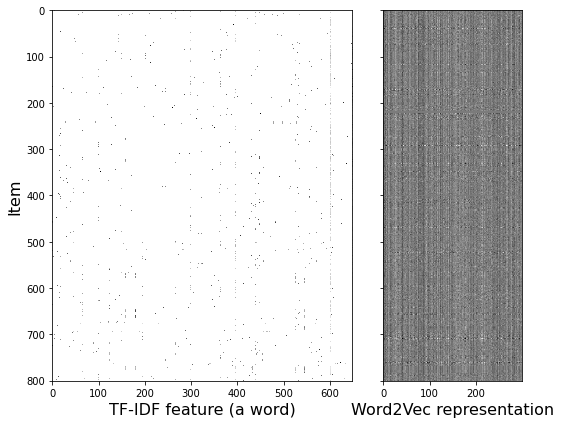

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(9,6), sharey=True, tight_layout=True)
ax[0].imshow(1-df2.values, interpolation='none', cmap="gray")
ax[1].imshow((1-df3.values), interpolation='none', cmap="gray")
ax[0].set_ylabel("Item", fontsize=16)
ax[0].set_xlabel("TF-IDF feature (a word)", fontsize=16)
ax[1].set_xlabel("Word2Vec representation", fontsize=16)
plt.savefig("images/representations.pdf")
